# Problemstellung (Rotter)

Das Ziel von Image Inpainting ist es, fehlende oder beschädigte Informationen aus Bild- oder Videomaterial zu rekonstruieren. Die Technik des Image Inpainting hat eine Vielzahl von Use-Cases ermöglicht. Image Inpainting wird aber nicht ausschließlich für fehlende Pixel verwendet, sondern auch für Aufgaben wie zum Beispiel dem Schärfen von Bildern, dem Entfernen von Rauschen oder dem Entfernen von Artefakten. 

# Herausforderungen (Rotter)

Die große Herausforderung ist es, die fehlenden oder beschädigten Teile von Bildern oder Videos sowohl visuell, als auch semantisch passend zu füllen. 

Convolutional Neural Networks (CNN) sind speziell für Rasterförmige Datensätze geeignet. Bilder können dabei als 2D Raster von Pixeln mit unterschiedlichen Farb- und Helligkeitswerten angesehen werden. Die Herausforderung bei der Umsetzung von Image Inpainting mit CNNs ist es, das Netzwerk so zu trainieren, dass es sinnvolle Vorhersagen für die fehlenden Pixel trifft.

CNN-basierte Methoden können zu Grenzartefakten, verzerrten und unscharfen Flecken am rekonstruierten Bild führen. Diese Arten von Artefakten können durch Post-processing Methoden reduziert werden, die aber vergleichsweise viel Rechenleistung erfordern und nicht so allgemein anwendbar sind. 

# Architektur (Manser)

Unsere Architektur basiert auf einem konvolutionalen Autoencoder, einer speziellen Form eines Encoder-Decoder-Modells, das in der Bildverarbeitung insbesondere für Aufgaben wie Image Inpainting eingesetzt wird. Ziel ist es, fehlende Bildbereiche auf Basis des umgebenden Kontexts möglichst realistisch zu rekonstruieren.

## Encoder

Der Encoder besteht aus einer Sequenz von Convolutional Layers (z. B. mit 3×3-Filtern), gefolgt von nichtlinearen Aktivierungsfunktionen (typischerweise ReLU - Rectified Linear Unit) und Downsampling mittels MaxPooling.
Diese Kombination reduziert die räumliche Auflösung des Bildes und extrahiert zunehmend abstrakte Merkmale. Dadurch wird eine komprimierte, semantisch bedeutungsvolle Darstellung erzeugt. [Rosebrock (2020)]

## Pooling
**Pooling** reduziert die räumliche Auflösung einer Merkmalskarte, indem in kleinen Bereichen (z.B. 2x2 Pixel) jeweils ein einzelner Wert berechnet wird - typischerweise das Maximum (MaxPooling) oder der Mittelwert (AveragePooling). Dadurch werden Informationen verdichtet und die Modellkomplexität verringert.

## Bottleneck

Im Zentrum der Architektur befindet sich der sogenannte **Bottleneck**, eine stark verdichtete Repräsentation des ursprünglichen Bildinhalts. Sie enthält alle wesentlichen Informationen, um das Bild – inklusive der maskierten Bereiche – wiederherzustellen.
Der Bottleneck spielt eine zentrale Rolle bei der semantischen Vervollständigung des Bildes und ist charakteristisch für alle Autoencoder-basierten Ansätze.

## Decoder

Der **Decoder** kehrt den Prozess des Encoders um: Mithilfe von **Transposed Convolutions** oder **Upsampling + Convolution** wird das Bild schrittweise wieder auf seine ursprüngliche Größe gebracht. Dabei werden auch die **fehlenden Bildbereiche** rekonstruiert. Der Artikel von Weights & Biases (2022) betont, dass CNNs besonders gut darin sind, sowohl **lokale Strukturen** als auch den **globalen Kontext** wiederherzustellen - ein zentrales Kriterium für glaubwürdiges Image Inpainting.

Ein Beispielbild einer Autoencoder-Architektur kann im [Appendix A8](#appendix-a8) gesehen werden.

# Praktische Anwendung

## Datensatz

Für dieses Projekt wird der CIFAR-10-Datensatz verwendet, der vom *Canadian Institute for Advanced Research (CIFAR)* in Zusammenarbeit mit der *University of Toronto* entwickelt wurde. [Krizhevsky (2009)]

- Wichtige Informationen:
    - **Umfang**: 60.000 farbige Bilder
    - **Auflösung**: 32x32 Pixel pro Bild (1.024 Pixel)
    - **Farbkanal**: RGB-Kanal (Rot, Grün, Blau)
    - **Aufteilung**:
      - 10 Klassen (z.B. Flugzeug, Autos, Vögel, Katzen, etc.)
      - jeweils 6.000 Bilder pro Klasse
      - 50.000 Trainings-Bilder
      - 10.000 Test-Bilder


#### Eignung des Datensatzes für Image Inpainting

- Der CIFAR-10-Datensatz eignet sich hervorragend zur Demonstration von Inpainting-Verfahren mit CNNs, da er:
    - kompakt und damit auch ohne GPU effizient verarbeitbar ist
    - visuell vielfältig ist – die Bilder enthalten erlernbare Strukturen, Farben und Objekte
    - als RGB-Datensatz auch für reale Szenarien übertragbar ist

Die gewählte Autoencoder-Architektur kann so auf eine große Menge sinnvoller Trainingsdaten angewendet werden, ohne dass große Rechenressourcen benötigt werden.

### Vorschau der Bilder des Datensatzes
Hier sind die ersten zehn Trainingsbilder aus dem CIFAR-10-Datensatz dargestellt, jeweils inklusive ihres zugehörigen Labels. Sie repräsentieren den ursprünglichen Zustand vor der Maskierung und dienen als Referenz für die Inpainting-Aufgabe.

![CIFAR-10 Beispiele](./results/cifar10_prewiev.png)

**Abbildung:** Zehn zufällige Bilder aus dem CIFAR-10-Datensatz mit zugehörigen Klassenlabels.

Der Code zum Laden und Vorverarbeiten des Datensatzes ist im [Appendix A2](#appendix-a2) zu finden.

### Bewertung der Bildqualität des Datensatzes

Bereits bei der ersten Betrachtung der CIFAR-10-Bilder zeigt sich deutlich, dass die Bildqualität vergleichsweise niedrig ist. Dies liegt an der Auflösung von nur 32×32 Pixeln, was bei vielen Objekten zu einem verschwommenen oder grob gepixelten Eindruck führt. Dennoch lässt sich die Objektklasse (z. B. „Auto“, „Vogel“, „Schiff“) in vielen Fällen noch erkennen, was für unsere Experimente im Bereich Image Inpainting ausreichend ist.

## Maskierung der Trainingsdaten

Um das Modell auf die Aufgabe des Image Inpainting vorzubereiten, werden die Trainings- und Testbilder aus dem CIFAR-10-Datensatz vor dem Training künstlich beschädigt, indem auf jedem Bild ein zufälliges Rechteck (Mask) eingefügt wird. Dieser Bereich wird vollständig auf null gesetzt, d. h. auf schwarze Pixelwerte (0, 0, 0 in RGB).

Die Maskierung dient als gezielte Datenverfremdung, bei der das Modell lernen soll, den fehlenden Bereich rein auf Basis des umgebenden Kontexts zu rekonstruieren. Dabei variiert die Größe und Position der Maske zufällig bei jedem Bild und jeder Epoche, was die Generaliserungsfähigkeit des Modells erhöht und Overfitting auf eine bestimmte Maskenform verhindert.

### Beispiel: Maskierte CIFAR-10-Bilder

Zur Veranschaulichung zeigt die folgende Abbildung zehn maskierte Trainingsbilder, die aus der Originalmenge erzeugt wurden. Die jeweiligen Objekte (z. B. Flugzeug, Auto, Katze) sind teilweise verdeckt, sodass eine Rekonstruktion durch das Modell notwendig wird.

![Maskierte Trainingsbilder](./results/cifar10_masked_preview.png)

**Abbildung**: Die zehn ersten maskierten Trainingsbilder aus dem CIFAR-10-Datensatz.

Der vollständige Code zur Generierung der Masken befindet sich im [Appendix A3](#appendix-a3)

## Erstellung des Autoencoders

Der Autoencoder wurde in Keras mit dem TensorFlow-Backend implementiert. Die Architektur besteht aus einem Encoder- und einem Decoder-Teil, die symmetrisch aufgebaut sind.

- Encoder:
  - Zwei Convolutional Layers mit 3×3-Filtern und ReLU-Aktivierung
  - Jeweils gefolgt von einem MaxPooling2D, um die räumliche Dimension zu halbieren
  - Ziel: Komprimierung der Bildinformation und Extraktion abstrakter Merkmale

- Bottleneck:
  - Kompakte Repräsentation der Bildinformationen, die später zur Rekonstruktion verwendet wird

- Decoder:
  - Zwei Convolutional Layers mit UpSampling, um die Bildgröße wieder auf 32×32 Pixel zu bringen
  - Die finale Schicht nutzt einen sigmoid-Aktivierungsfunktion, um RGB-Werte im Bereich [0, 1] auszugeben

Das Modell wurde mit dem Adam-Optimizer trainiert und nutzt Binary Crossentropy als Verlustfunktion, da die Ausgabe-Pixelwerte als Wahrscheinlichkeiten interpretiert werden können.

Die Implementierung ist im [Appendix A4](#appendix-a4) dokumentiert.

## Training des Autoencoders

Das Modell wurde auf den maskierten CIFAR-10-Bildern trainiert, wobei die Eingabe jeweils ein Bild mit einer zufälligen Rechteck-Maske war und das Zielbild das originale, unmaskierte Bild darstellte.

Trainingseinstellungen:
- Epochen: Maximal 40
- Batch-Größe: 128
- Optimierer: Adam
- Verlustfunktion: Binary Crossentropy
- Shuffle: Aktiviert, um die Trainingsdaten bei jedem Durchlauf neu zu mischen
- Validierungsdaten: Separate Testdaten mit zufälliger Maskierung

Zur Vermeidung von Overfitting wurde ein EarlyStopping-Callback verwendet. Dieses stoppt das Training automatisch, wenn sich der Validierungsverlust über fünf Epochen hinweg nicht mehr verbessert. Gleichzeitig werden die besten Gewichte aus dem Training gespeichert.

Der **komplette Code zum Training** befindet sich im [Appendix A5](#appendix-a5).


## Ergebnisse

Nach dem Training des Autoencoders wurde das Modell verwendet, um neue, maskierte Testbilder aus dem CIFAR-10-Datensatz zu rekonstruieren. Die folgenden Visualisierungen zeigen beispielhaft den Vergleich zwischen:
1. dem Originalbild (oben),
2. der maskierten Version des Bildes (Mitte) und
3. der rekonstruierten Ausgabe des Autoencoders (unten).

Dabei wurde auf dieselben zehn Testbilder zurückgegriffen, um eine visuell nachvollziehbare Beurteilung der Rekonstruktionsqualität zu ermöglichen. Die Masken wurden erneut zufällig erzeugt, um die Generalisierungsfähigkeit des Modells zu demonstrieren.

![Ergebnisse](./results/inpainting_result_cifar10.png)

**Abbildung**: Vergleich der Originalbilder, maskierten Eingabebilder und rekonstruierten Ausgaben für zehn Beispiele aus dem Testdatensatz.

### Interpretation

Die Ergebnisse zeigen, dass das Modell in vielen Fällen in der Lage ist, fehlende Bildbereiche plausibel zu ergänzen. Besonders bei symmetrischen oder texturarmen Objekten wie Autos, Schiffen oder Hintergründen gelingt die Rekonstruktion visuell überzeugend. Komplexere Strukturen wie Vögel oder Katzenköpfe stellen das Modell hingegen vor größere Herausforderungen, was sich in leicht unscharfen oder ungenauen Rekonstruktionen zeigt.

Insgesamt funktioniert das Inpainting bereits gut, dennoch sind bei genauerer Betrachtung weiterhin klare Unterschiede zwischen dem Originalbild und der rekonstruierten Version erkennbar – insbesondere in Bereichen mit feinen Details oder komplexen Kantenstrukturen.

Hinzu kommt, dass die CIFAR-10-Bilder aufgrund ihrer geringen Auflösung von nur 32×32 Pixeln bereits im Original relativ unscharf sind, was die Rekonstruktionsgenauigkeit zusätzlich erschwert. Diese Unschärfe begrenzt die visuelle Vergleichbarkeit und stellt eine zusätzliche Herausforderung für das Modell dar.

Der vollständige Code zur Erstellung dieser Visualisierung befindet sich im [Appendix A6](#appendix-a6).


![Plot: Test- vs. Validierungsfehler beim Trainieren des CNNs](./results/verlaufsdiagramm_verlust.png)

**Abbildung**: Verlauf des Trainings- und Validierungsverlusts (Loss) über 40 Epochen beim Training des Autoencoders

Die Visualisierung zeigt, wie sich die Verlustwerte während des Trainings entwickeln. Beide Kurven zeigen einen deutlich abnehmenden Trend, was darauf hindeutet, dass der Autoencoder erfolgreich lernt, die maskierten Bildbereiche zu rekonstruieren.

Der Trainingsverlust sinkt stetig, während der Validierungsverlust ein ähnliches Verhalten zeigt – wenn auch mit etwas stärkeren Schwankungen. Diese Differenz ist - meines Wissens - normal und lässt sich auf die unterschiedliche Zusammensetzung der Trainings- und Testdaten zurückführen.

Wichtig ist, dass die beiden Kurven relativ nahe beieinander verlaufen, was gegen Overfitting spricht. Das Early-Stopping-Callback sorgte zudem dafür, dass das Modell automatisch an dem Punkt gespeichert wurde, an dem der Validierungsverlust am niedrigsten war.

Der vollständige Code zur Erstellung dieses Plots ist ebenfalls im [Appendix A6](#appendix-a6) dokumentiert.


## Ausblick

Aufgrund begrenzter zeitlicher Ressourcen konnten im Rahmen dieses Projekts nur grundlegende Experimente mit einem einfachen Autoencoder und dem CIFAR-10-Datensatz durchgeführt werden. Dennoch liefern die Ergebnisse einen soliden ersten Einblick in die Funktionsweise von CNN-basiertem Image Inpainting.

Für eine Weiterentwicklung des Projekts wären folgende Schritte sinnvoll:

1. **Verwendung eines höher aufgelösten Datensatzes**
2. **Komplexere Netzwerkarchitekturen** (z.B. GAN basierte Modelle wie Context Encoder)
3. **Integration von Post-Processing-Techniken** wie Bildglättung oder Kantenschärfung

Diese Erweiterungen würden es ermöglichen, das Modell robuster, vielseitiger und realitätsnäher zu gestalten – sowohl im Hinblick auf Datensätze als auch auf Architektur und Evaluation.

# Literaturverzeichnis 
- Waghela, V. (2022). Image Inpainting using CNN. Kaggle.
https://www.kaggle.com/code/vidhikishorwaghela/image-inpainting-using-cnn

- Weights & Biases. (2022). Introduction to Image Inpainting with Deep Learning.
https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5

- Rosebrock, A. (2020). Autoencoders with Keras, TensorFlow, and Deep Learning.
https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

- Krizhevsky, A (2009). Learning Multiple Layers of Features from Tiny Images.  
https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

\newpage
# Executive Summary

## CIFAR-10 Datensatz - Kurzbeschreibung
Der vom *Canadian Institute for Advanced Research (CIFAR)* in Kooperation mit der *University of Toronto* entwickelte CIFAR-10 Datensatz besteht aus 60.000 32x32 Farbbildern unterteilt in 10 Klassen. Jede Klasse beinhaltet 6.000 Bilder, wobei der Datensatz in 50.000 Trainings- und 10.000 Testbilder unterteilt ist. Die 10 Klassen lauten wie folgt: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Weder die Klasse automobile, noch truck enthalten Bilder von Pick-up Trucks.

## Image Inpainting mit CNNs - Methodik
Für den Prozess des Image Inpaintings wurde ein *convolutional Autoencoder* eingesetzt. Das ist ein neuronales Netz mit Encoder-Decoder Struktur. Dabei reduziert der Encoder die Informationen aus den Bildern auf eine kompakte, semantisch bedeutungsvolle Representation, die als "Bottleneck" bezeichnet wird.  
Der Decoder rekonstruiert daraus in Folge die Originalgröße der Bilder und füllt die maskierten Bereiche plausibel auf. Die Architektur wird in Keras mit TensorFlow umgesetzt, wobei das CIFAR-10 Datenset zum Training dient. Jedes Bild wird mit einem Quadrat, das zufällig über die Bilder gelegt wird maskiert, um dem Modell so die Rekonstruktion fehlender Bildteile "beizubringen". 

## Verwendete Software
Für optimale Kompatibilität mit dem verwendeten TensorFlow Paket, wird die Python Version 3.10 für das Training und den Inpainting Prozess angewandt. Außer dem TensorFlow Paket werden auch die pandas, numpy und matplotlib Pakete für Datenmanipulation, Berechnungen und Visualisierungen verwendet. Für den Vorgang des maschinellen Lernens (ML) wird die Keras API, die Teil der TensorFlow Platform ist, eingesetzt. 


## Erkenntnisse und Resultate
Das trainierte Modell ist in der Lage, fehlende Bildbereiche großteils *plausibel zu ergänzen*. Bei symmetrischen oder weniger komplexen Bildelementen funktioniert der inpainting Prozess tendenziell besser. Die *optische Qualität* der rekonstruierten Bilder ist grundsätzlich akzeptabel, wobei das Modell auch auf neue Maskierungen *generalisieren* kann. Die Trainings- und Validierungskurven zeigen einen *stabilen Lernverlauf*, wobei kein "overfitting" erkennbar ist. Besonders bei *feinen oder komplexen Strukturen* kommt das Modell an seine Grenzen und zeigt seine Schwächen. Die sehr geringe Auflösung der CIFAR-10 Bilder von 32x32 Pixeln und der relativ kleine Datensatz begrenzen die visuelle Detailtreue.

## Zentrale Herausforderungen
Die zentrale Herausforderung ist die Erstellung von *semantisch sinnvollen und optisch realistischen Rekonstruktionen* von maskierten Bildbereichen. CNNs neigen bei ungenauen Vorhersagen zu *Artefakten, Unschärfe oder Verzerrungen*, besonders an den Grenzen zwischen Masken und Originalbildern. Post-Processing Methoden, die nach dem Inpainting Prozess angewandt werden, um solche Artefakte zu verbessern, erfordern zusätzliche Rechenleistung und sind nur eingeschränkt generalisierbar. Die geringe Auflösung der Bilder des CIFAR-10 Datensatzes stellen ebenfalls eine Herausforderung dar, da schon viele Details aus den Originalbildern abstrahiert sind.  

\newpage
# Appendix

## A1 - Code: Imports und Setup <a id="appendix-a1"></a>

### Setup:

Für die erfolgreiche Installation von TensorFlow ist die verwendete Python-Version entscheidend. TensorFlow 2.19.0 ist z. B. nicht kompatibel mit Python 3.13.
Wir verwenden daher gezielt **Python 3.10**, da diese Version offiziell von TensorFlow unterstützt wird und mit allen verwendeten Paketen kompatibel ist.

### Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## A2 - Code: Laden & Vorverarbeitung der Daten <a id="appendix-a2"></a>

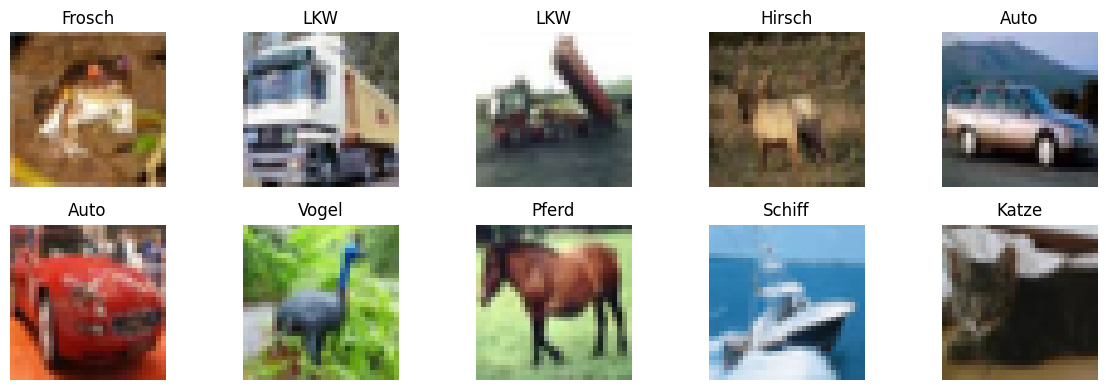

In [8]:
# CIFAR-10 laden
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalisieren (Wertebereich 0 - 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# CIFAR-10 Klassenlabels
class_names = ['Flugzeug', 'Auto', 'Vogel', 'Katze', 'Hirsch', 'Hund', 'Frosch', 'Pferd', 'Schiff', 'LKW']

# Zeige die ersten 10 Bilder mit Label
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.savefig("./results/cifar10_prewiev.png", dpi=300)
plt.show()

## A3 - Code: Maskierung <a id="appendix-a3"></a>

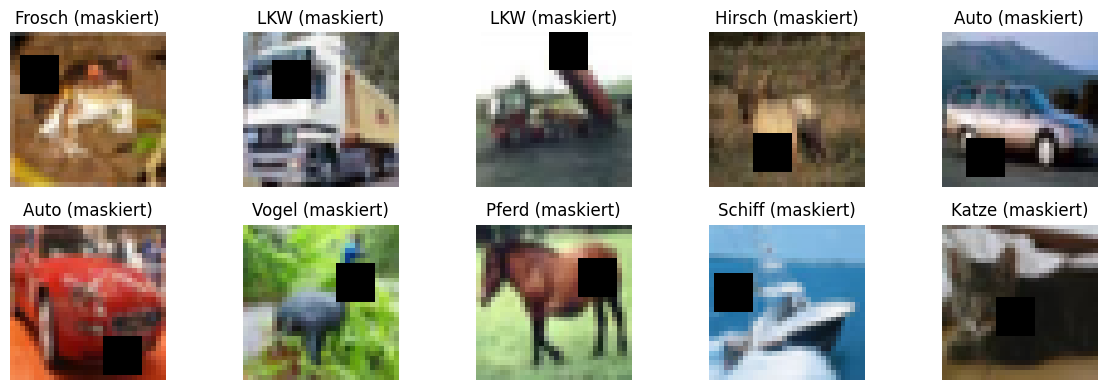

In [10]:
def add_random_rectangle_mask(images, mask_size=(8, 8)):
    masked = np.copy(images)
    for img in masked:
        h, w = img.shape[:2]
        top = np.random.randint(0, h - mask_size[0])
        left = np.random.randint(0, w - mask_size[1])
        img[top:top+mask_size[0], left:left+mask_size[1], :] = 0.0
    return masked

x_train_masked = add_random_rectangle_mask(x_train)
x_test_masked = add_random_rectangle_mask(x_test)

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_masked[i])
    plt.title(f"{class_names[y_train[i][0]]} (maskiert)")
    plt.axis('off')
plt.tight_layout()
plt.savefig("./results/cifar10_masked_preview.png", dpi=300)
plt.show()

## A4 - Code: Autoencoder-Architektur <a id="appendix-a4"></a>

In [ ]:
input_img = Input(shape=(32, 32, 3))

# Teil 1: Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Teil 2: Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

## A5 - Code: Training & Callbacks <a id="appendix-a5"></a>

In [16]:
# Callback definieren, damit das Training (Epochs) bei gewisser Bedingung abbricht
# hier: Training stoppt automatisch, wenn sich der Validierungsverlust 5 Epochen lang nicht verbessert

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x_train_masked, x_train,
    epochs=40,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_masked, x_test),
    callbacks=[early_stop]
)

pd.DataFrame(history.history).to_csv("results/training_log.csv")

Epoch 1/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - loss: 0.5598 - val_loss: 0.5609
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 0.5604 - val_loss: 0.5608
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.5605 - val_loss: 0.5605
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - loss: 0.5598 - val_loss: 0.5604
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - loss: 0.5593 - val_loss: 0.5605
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 0.5598 - val_loss: 0.5605
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 0.5594 - val_loss: 0.5604
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - loss: 0.5597 - val_loss: 0.5604
Epoch 9/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - loss: 0.5594 - val_loss: 0.5601
Epoch 10/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - loss: 0.5596 - val_loss: 0.5600
Epoch 11/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - loss: 0.5593 - val_loss: 0.5604
Epoch 12/40
391/391 ━━━━━━━━━━

## A6 - Code: Visualisierung & Evaluation <a id="appendix-a6"></a>

### a: Vergleich: Original vs Maskiert vs Rekonstruiert

In [ ]:
decoded_imgs = autoencoder.predict(x_test_masked[:10])

n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1) # plt.subplot(nrows, ncols, index)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Masked
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_masked[i])
    plt.title("Masked")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.savefig("./results/inpainting_result_cifar10.png", dpi=300)
plt.show()

### b: Trainings- vs Validierungsverlust

In [ ]:
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.title('Trainings- vs. Validierungsverlust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./results/verlaufsdiagramm_verlust.png", dpi=300)
plt.show()

## A7 - Code: Speichern & Laden <a id="appendix-a7"></a>

In [14]:
autoencoder.save("models/autoencoder_cifar10.keras")

autoencoder = load_model("models/autoencoder_cifar10.keras")

## A8 - Abbildung einer Autoencoder Architektur <a id="appendix-a8"></a>

![Abbildung einer Autoencoder-Architektur](./images/image_autoencoder.png)

**Abbildung:** Darstellung eines symmetrischen Autoencoders mit Encoder, Bottleneck („Code“) und Decoder. Diese Architekturform bildet die Grundlage vieler Inpainting-Modelle.  
Quelle: Weights & Biases (2022) – [Introduction to Image Inpainting with Deep Learning](https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5)